<a href="https://colab.research.google.com/github/Gblack98/PestVisionAI/blob/Gabar_001/Tomato_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
noulam_tomato_path = kagglehub.dataset_download('noulam/tomato')

print('Data source import complete.')


100%|██████████| 743M/743M [00:07<00:00, 108MB/s]

Extracting files...


Data source import complete.


In [2]:
# import os

# base_path = noulam_tomato_path
# for root, dirs, files in os.walk(base_path):
#     print(root)


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2  # Lecture d'images si nécessaire (optionnel)
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2  # Lecture d'images si nécessaire
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [6]:

# --- Configuration des hyperparamètres ---
IMG_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 100
NUM_CLASSES = 10
SEED = 1337
LEARNING_RATE = 1e-3

# Assurer la reproductibilité
tf.keras.utils.set_random_seed(SEED)

# --- Vérification de l'utilisation du GPU (T4) ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU détecté : {gpus[0].name}")
else:
    print("⚠️ Aucun GPU détecté. Vérifiez les paramètres d'exécution.")

# --- Création du modèle CNN ---
def create_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    model = Sequential([
        Input(shape=input_shape),  # Définition explicite de l'entrée

        # Bloc 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Bloc 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.35),

        # Bloc 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.45),

        # Couche entièrement connectée
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# --- Préparation des données avec augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# --- Chemins du dataset (Colab après import Kaggle) ---
train_dir = '/root/.cache/kagglehub/datasets/noulam/tomato/versions/1/New Plant Diseases Dataset(Augmented)/train'
val_dir = '/root/.cache/kagglehub/datasets/noulam/tomato/versions/1/New Plant Diseases Dataset(Augmented)/valid'

# --- Générateurs de données ---
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --- Utilisation du GPU avec MirroredStrategy ---
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
print(f"🔧 Entraînement avec la stratégie : {strategy.__class__.__name__}")

# --- Création et compilation du modèle sous stratégie ---
with strategy.scope():
    model = create_model()
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# --- Callbacks ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=5e-4),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# --- Entraînement ---
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    callbacks=callbacks
)

✅ GPU détecté : /physical_device:GPU:0
Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.
🔧 Entraînement avec la stratégie : MirroredStrategy


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 121s 396ms/step - accuracy: 0.4696 - loss: 19.6454 - val_accuracy: 0.1101 - val_loss: 9.5904 - learning_rate: 0.0010
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 113s 391ms/step - accuracy: 0.7355 - loss: 4.6212 - val_accuracy: 0.4366 - val_loss: 5.7918 - learning_rate: 0.0010
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 142s 392ms/step - accuracy: 0.7763 - loss: 3.8744 - val_accuracy: 0.5045 - val_loss: 4.7876 - learning_rate: 0.0010
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 112s 389ms/step - accuracy: 0.8047 - loss: 3.5204 - val_accuracy: 0.3498 - val_loss: 7.7741 - learning_rate: 0.0010
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 117s 408ms/step - accuracy: 0.8321 - loss: 3.0418 - val_accuracy: 0.5594 - val_loss: 4.6453 - learning_rate: 0.0010
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 111s 387ms/step - accuracy: 0.8527 - loss: 3.2262 - val_accuracy: 0.4454 - val_loss: 6.2547 - learning_rate: 0.0010
Epoch 7/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 143s 393ms/step 

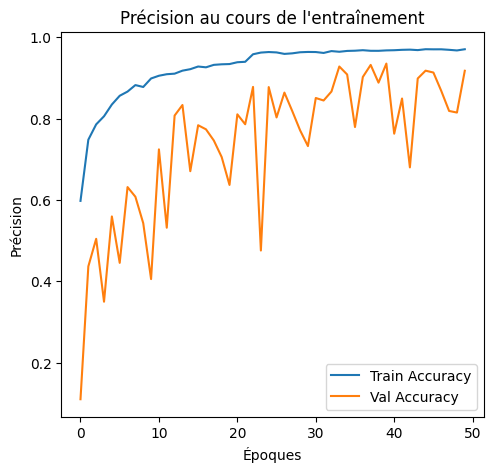

In [7]:
# --- Visualisation des courbes d'apprentissage ---
plt.figure(figsize=(12, 5))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.title('Précision au cours de l\'entraînement')
plt.legend()


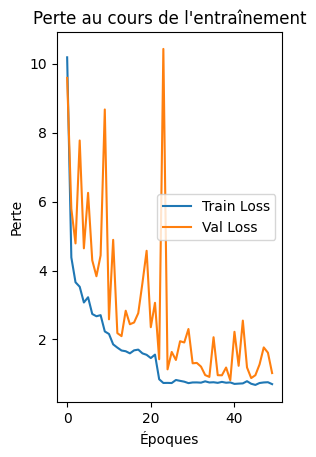

In [8]:

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Perte au cours de l\'entraînement')
plt.legend()

plt.show()

In [9]:
# Évaluation finale
final_loss, final_acc = model.evaluate(val_generator)
print(f'\nValidation Accuracy: {final_acc:.2%}')
print(f'Validation Loss: {final_loss:.4f}')


72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9326 - loss: 0.8285

Validation Accuracy: 93.52%
Validation Loss: 0.8173


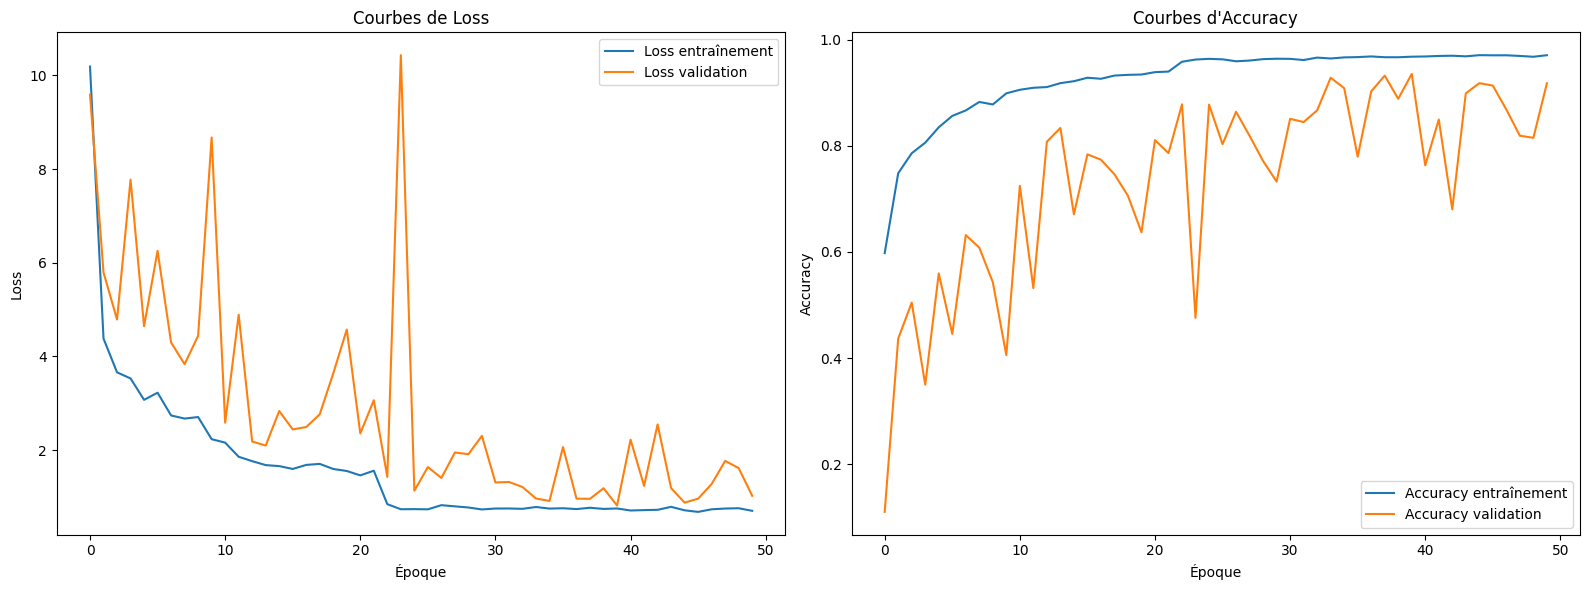

In [10]:
# -------------------------------
# Visualisations avancées
# -------------------------------

# 1. Courbes d'entraînement (Loss et Accuracy)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.title('Courbes de Loss')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy entraînement')
plt.plot(history.history['val_accuracy'], label='Accuracy validation')
plt.title('Courbes d\'Accuracy')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step


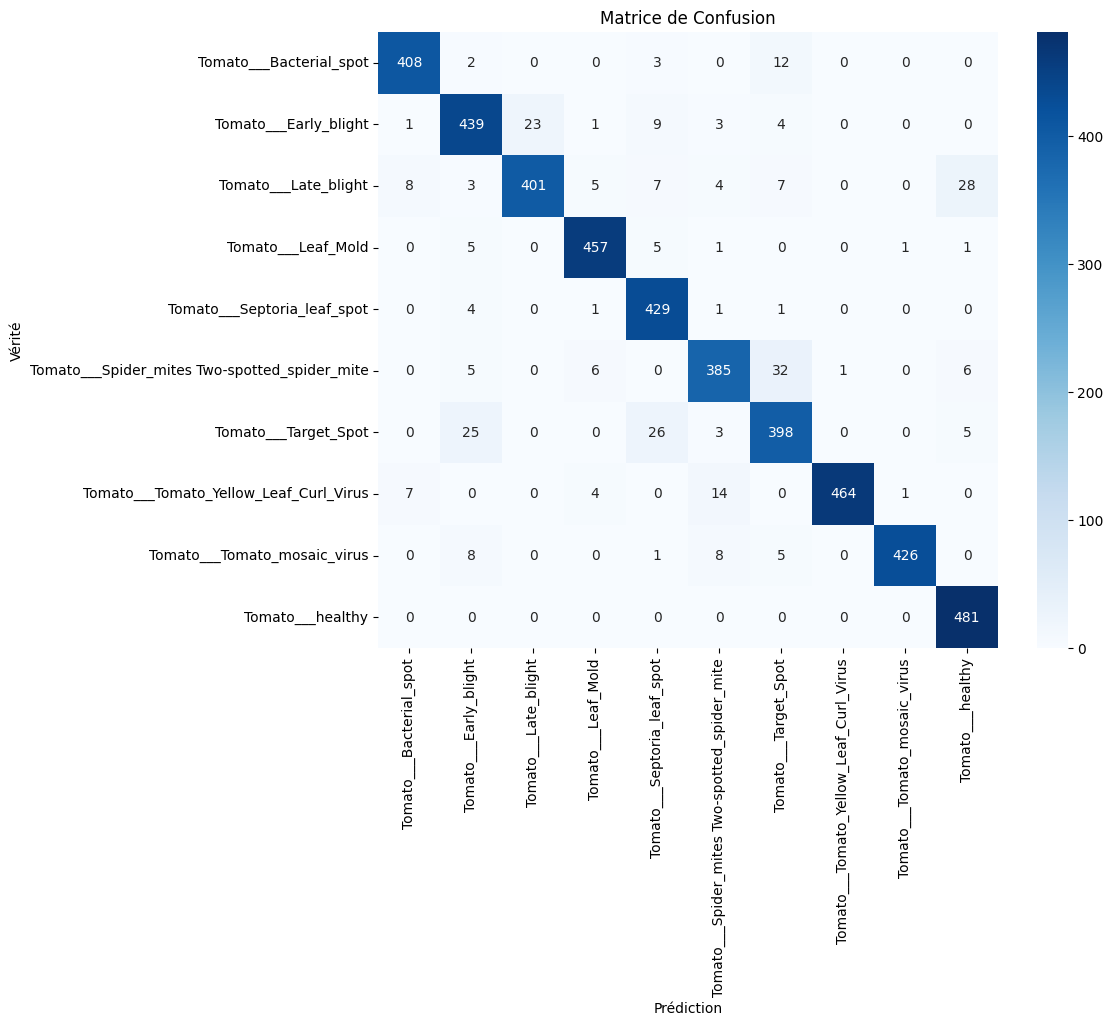

Rapport de Classification :
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.96      0.96      0.96       425
                        Tomato___Early_blight       0.89      0.91      0.90       480
                         Tomato___Late_blight       0.95      0.87      0.90       463
                           Tomato___Leaf_Mold       0.96      0.97      0.97       470
                  Tomato___Septoria_leaf_spot       0.89      0.98      0.94       436
Tomato___Spider_mites Two-spotted_spider_mite       0.92      0.89      0.90       435
                         Tomato___Target_Spot       0.87      0.87      0.87       457
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.95      0.97       490
                 Tomato___Tomato_mosaic_virus       1.00      0.95      0.97       448
                             Tomato___healthy       0.92      1.00      0.96       481

             

In [11]:
# 2. Matrice de confusion et rapport de classification
# Obtenir les prédictions sur l'ensemble de validation
val_generator.reset()
Y_pred = model.predict(val_generator, steps=val_generator.samples // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
class_labels = list(val_generator.class_indices.keys())

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matrice de Confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.show()

# Rapport de classification
print("Rapport de Classification :")
print(classification_report(y_true, y_pred, target_names=class_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step


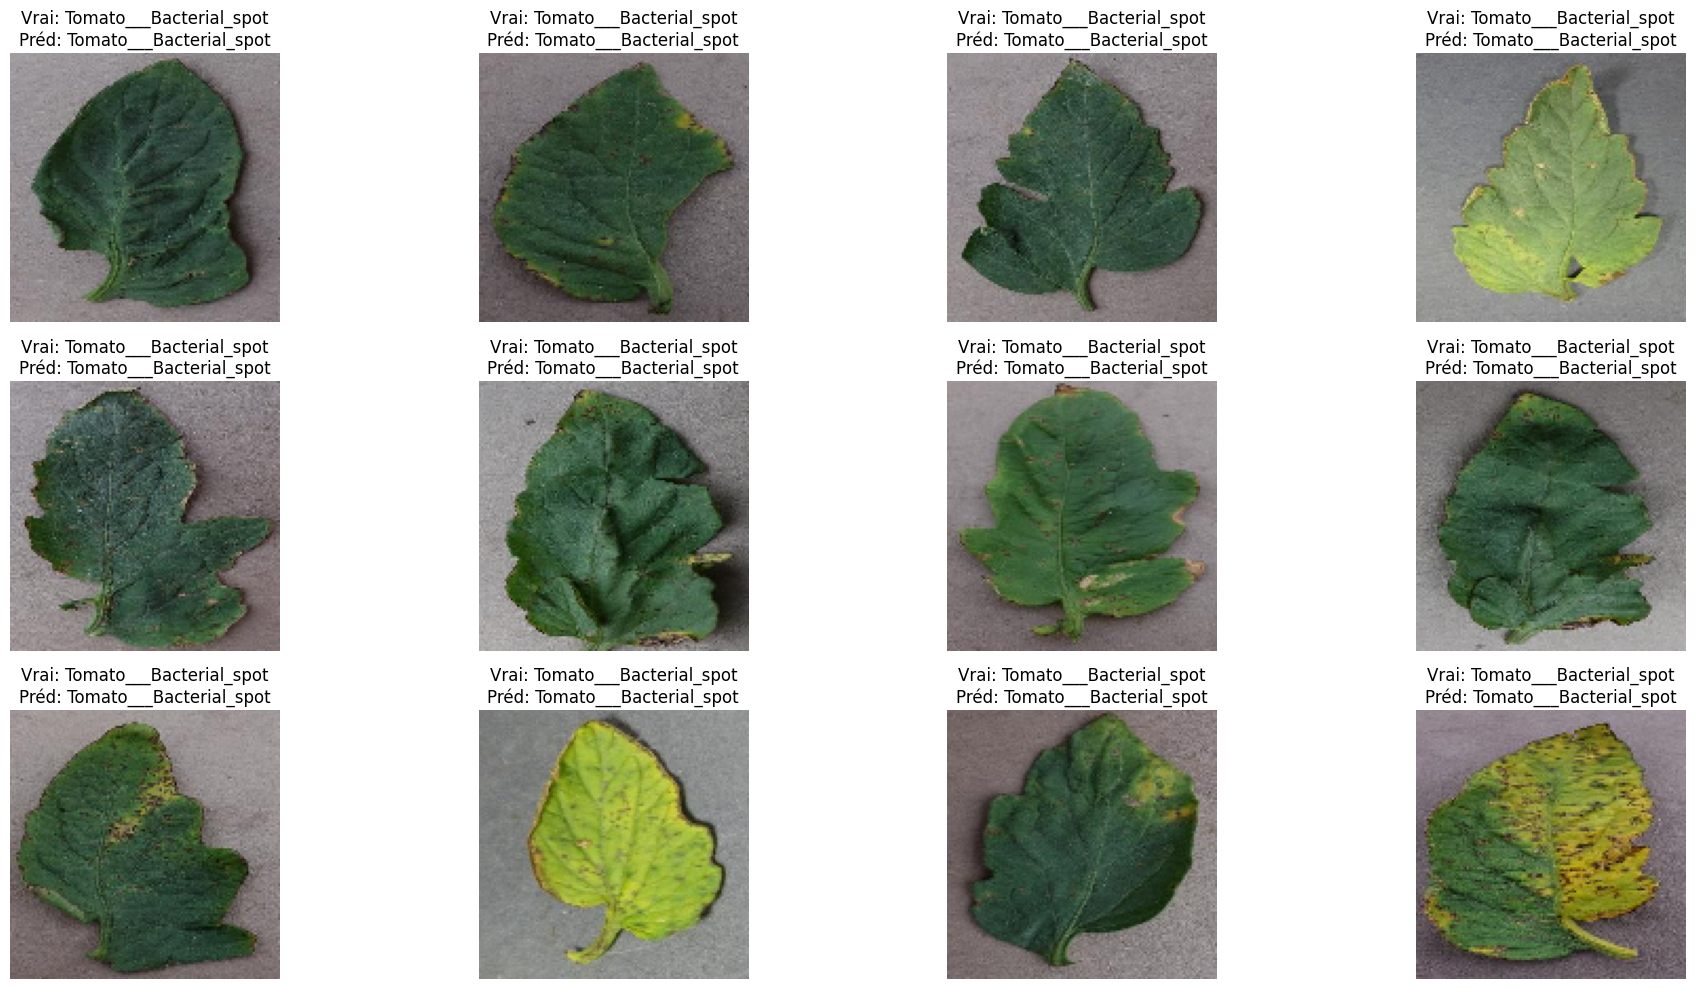

In [12]:
# 3. Affichage d'exemples d'images avec leurs prédictions
# Récupérer un batch d'images de validation
val_batch = next(val_generator)
images, labels = val_batch[0], val_batch[1]
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels, axis=1)

plt.figure(figsize=(20,10))
for i in range(12):
    idx = random.randint(0, images.shape[0]-1)
    plt.subplot(3,4,i+1)
    plt.imshow(images[idx])
    plt.title(f"Vrai: {class_labels[true_labels[idx]]}\nPréd: {class_labels[predicted_labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# Sauvegarde du modèle au format H5 ou SavedModel
model.save('best_model_1.keras')
